In [1]:
from mimic.utilities import *

from mimic.model_infer.infer_gLV_bayes import *
from mimic.model_infer import *
from mimic.model_simulate import *
from mimic.model_simulate.sim_gLV import *


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as at
import pickle
import cloudpickle


# Rutter & Dekker *et al* 2024 analysis

**This example replicates the analysis completed by Rutter & Dekker investigating the action of a bacteriocin released by one bacteria on another. The bacterial co-culture growth curves are used to infer the interaction of the species on each other.**

The two species are *E. coli* Nissle, which is a commensal strain engineered to secrete the bacteriocin, with the aim of killing the second species *Enterococcus faecalis*, which can be harmful to human health. In the paper, different bacteriocin and secretion tag combinations are tested, but in this example we demonstrate using one condition - PM3-EntA.

The priors selected for Bayesian inference are taken from the paper, which explores this and the model selection in more detail, as well as a thorough introduction to the data.

The original Rutter & Dekker *et al* paper can be found here: https://www.nature.com/articles/s41467-024-50591-8

### Data Preparation

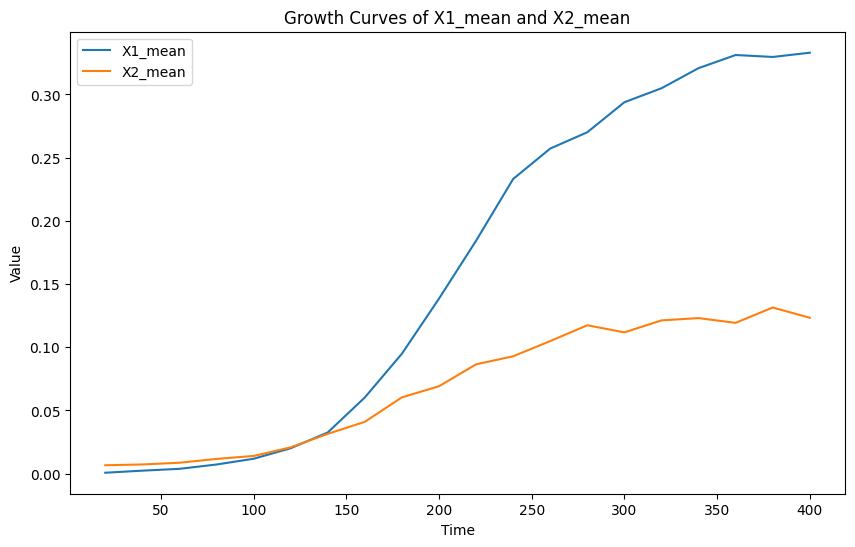

In [2]:
# read in the data
num_species = 2
num_timecourses = 4
data = pd.read_csv("PM3-EntA-coculture.csv")
data = data[(0 < data['time']) & (data['time'] <= 400)]  # Take only the first 400 minutes, excluding the first
times = data.iloc[:, 0].values

# Plot mean growth curves of each species
species_means = pd.DataFrame({
    "time": data.iloc[:,0],
    "X1_mean": data.iloc[:,[1,3,5,6]].mean(axis=1),
    "X2_mean": data.iloc[:,[2,4,6,8]].mean(axis=1)
})


# Plot growth curves
plt.figure(figsize=(10, 6))
plt.plot(species_means['time'], species_means['X1_mean'], label='X1_mean')
plt.plot(species_means['time'], species_means['X2_mean'], label='X2_mean')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Growth Curves of X1_mean and X2_mean')
plt.legend()
plt.show()

yobs = species_means.iloc[:,1:].to_numpy()

X, F = linearize_time_course_16S(yobs, times)


# Seperate and stack timecourses
yobs_1 = data.iloc[:, 1:(num_species+1)].values
yobs_2 = data.iloc[:, (num_species+1):(2*num_species+1)].values
yobs_3 = data.iloc[:, (2*num_species+1):(3*num_species+1)].values
yobs_4 = data.iloc[:, (3*num_species+1):(4*num_species+1)].values
ryobs = np.array([yobs_1, yobs_2, yobs_3, yobs_4])

# Replace negative values with 0
ryobs[ryobs < 0] = 0

#X = np.array([], dtype=np.double).reshape(0, num_species+1)
#F = np.array([], dtype=np.double).reshape(0, num_species)


#for timecourse_idx in range(num_timecourses):
#    Xs, Fs = linearize_time_course_16S(ryobs[timecourse_idx], times)
#    X = np.vstack([X, Xs])
#    F = np.vstack([F, Fs])
    



### Perform Bayesian inference without shrinkage

X shape: (19, 3)
F shape: (19, 2)
Number of species: 2
AdvancedSetSubtensor.0


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_hat, M_ii_hat_p, M_ij_hat]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


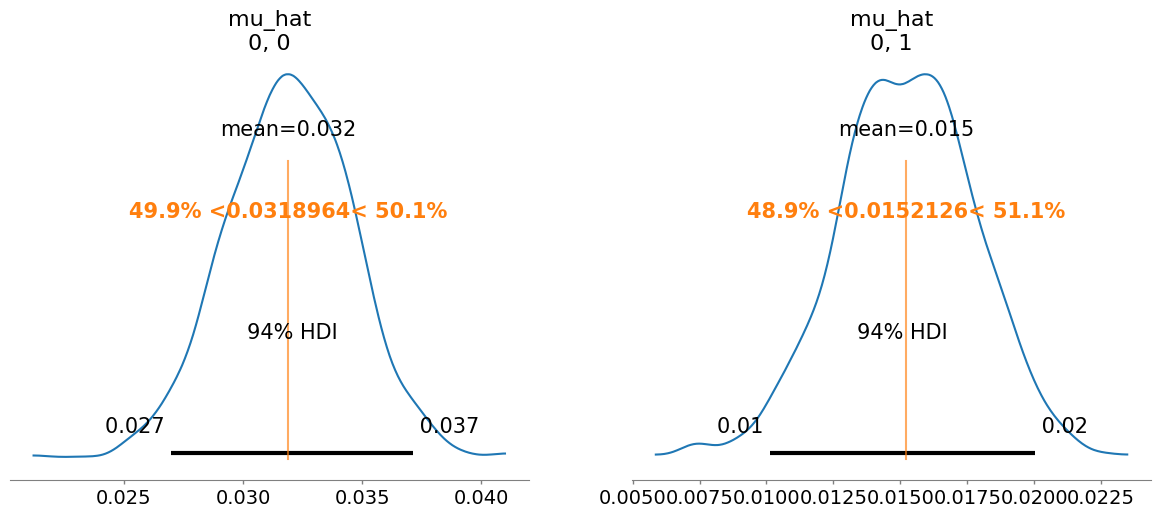

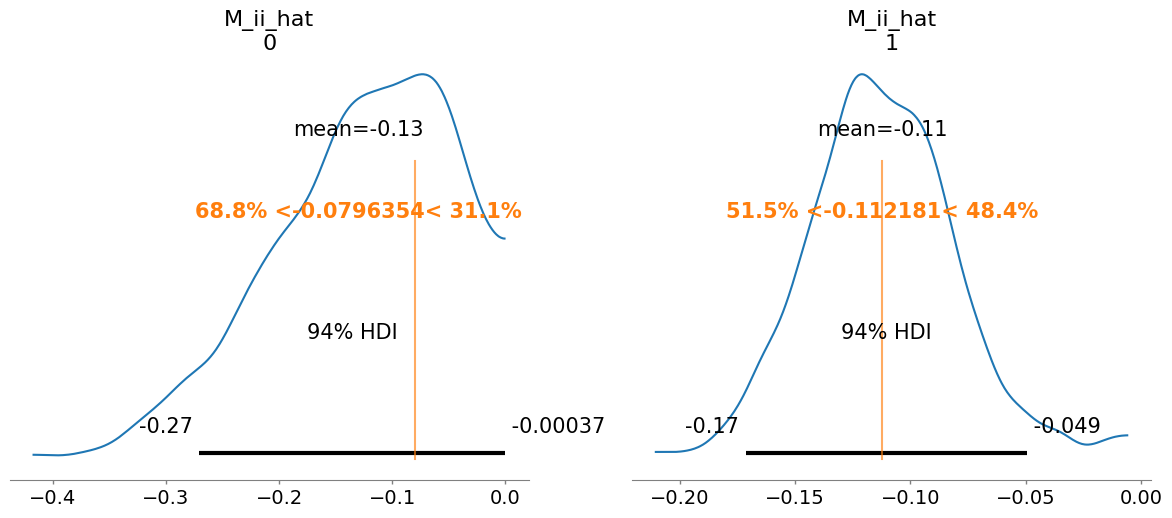

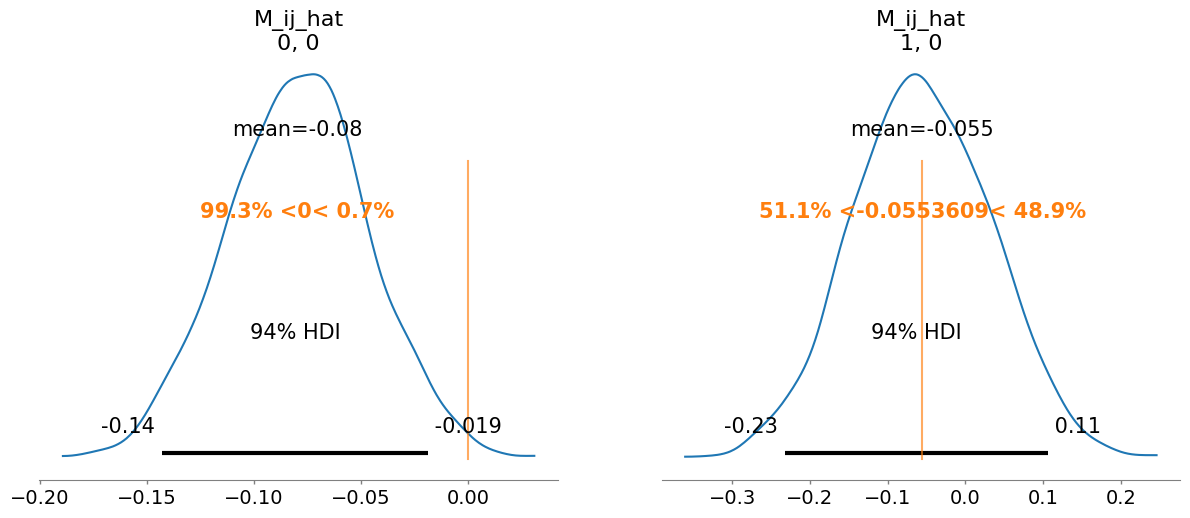

/Users/chaniaclare/Documents/GitHub/MIMIC/venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


                 mean     sd  r_hat
mu_hat[0, 0]    0.032  0.003   1.01
mu_hat[0, 1]    0.015  0.003   1.01
M_ii_hat[0]    -0.130  0.079   1.00
M_ii_hat[1]    -0.112  0.032   1.01
M_ij_hat[0, 0] -0.080  0.033   1.00
M_ij_hat[1, 0] -0.055  0.091   1.01
M_hat[0, 0]    -0.080  0.033   1.00
M_hat[0, 1]     0.000  0.000    NaN
M_hat[1, 0]    -0.055  0.091   1.01
M_hat[1, 1]    -0.112  0.032   1.01
sigma[0]        0.006  0.001   1.01


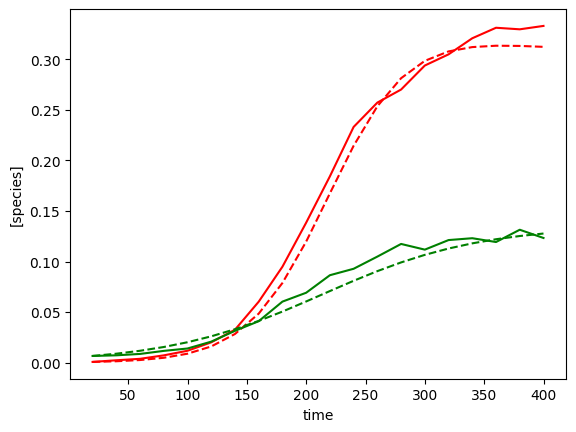

In [ ]:
# Perform Bayesian inference without shrinkage

# Define priors
prior_mu_mean = 0.03
prior_mu_sigma = 0.5

## NB prior_Mij_mean is 0, so not defined as an argument
prior_Mii_mean =  0.1

prior_Mii_sigma = 0.1

prior_Mij_sigma = 0.1


# Sampling conditions
draws = 500
tune = 500
chains = 4
cores = 4


# Run inference using parameters as set above
inference = infergLVbayes()

inference.set_parameters(X=X, F=F, prior_mu_mean=prior_mu_mean, prior_mu_sigma=prior_mu_sigma,
                          prior_Mii_sigma=prior_Mii_sigma, prior_Mii_mean=prior_Mii_mean,
                          prior_Mij_sigma=prior_Mij_sigma,
                          draws=draws, tune=tune, chains=chains,cores=cores)

idata = inference.run_inference()


# To plot posterior distributions
inference.plot_posterior(idata)

# Print summary
summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])


# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

# get median mu_hat and M_hat 
mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0,1) ).reshape(-1)
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1) )

# compare fitted with simulated parameters

predictor = sim_gLV(num_species=num_species, M=M_h.T, mu=mu_h)
yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=yobs[0])
plot_fit_gLV(yobs, yobs_h, times)




## Perform Bayesian inference with shrinkage

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_hat, M_ii_hat_p, c2, tau, lam, M_ij_hat]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
There were 205 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


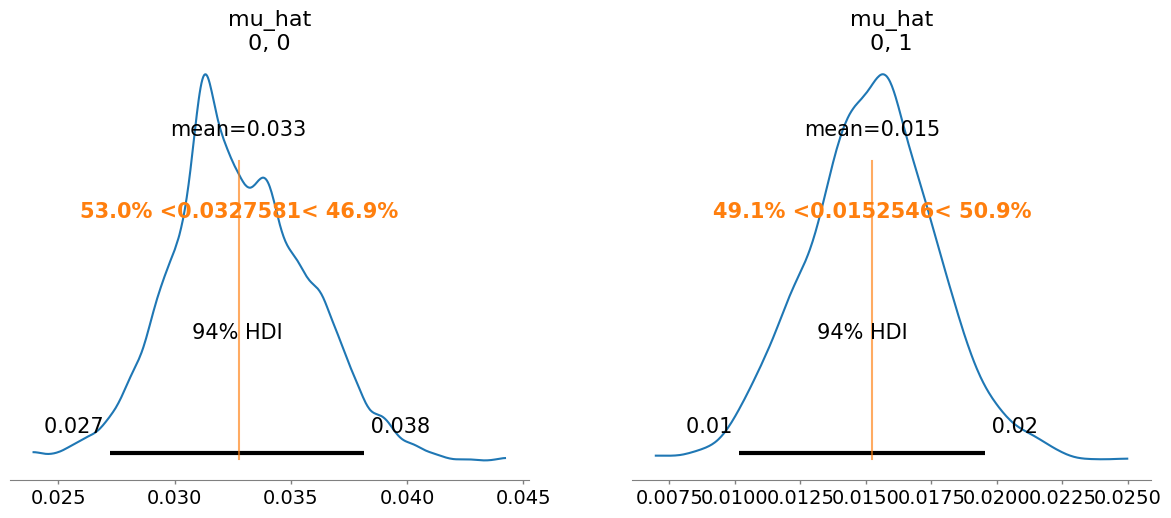

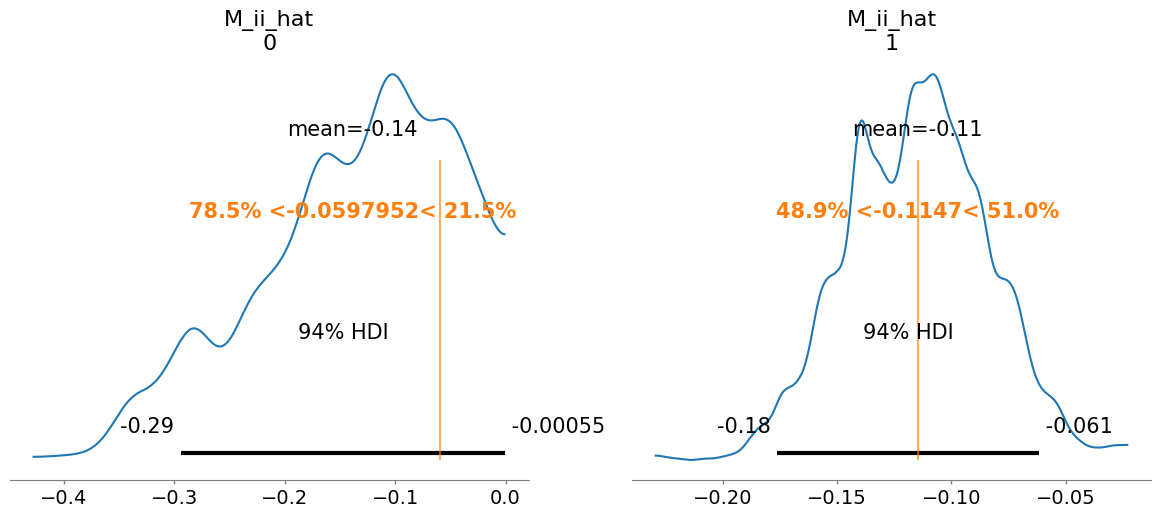

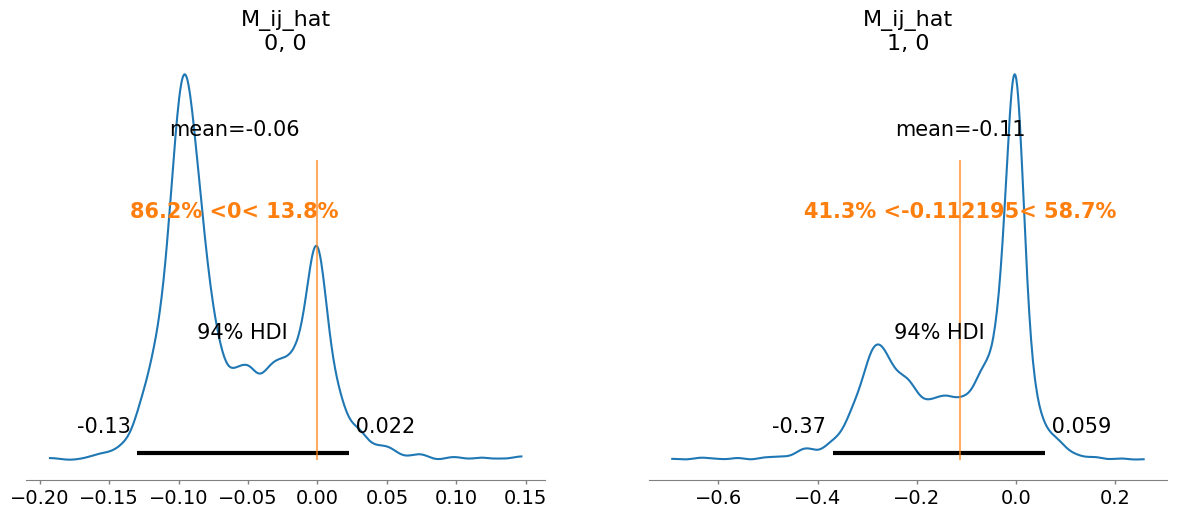

/Users/chaniaclare/Documents/GitHub/MIMIC/venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


                 mean     sd  r_hat
mu_hat[0, 0]    0.033  0.003   1.02
mu_hat[0, 1]    0.015  0.002   1.01
M_ii_hat[0]    -0.139  0.088   1.07
M_ii_hat[1]    -0.115  0.031   1.02
M_ij_hat[0, 0] -0.060  0.049   1.04
M_ij_hat[1, 0] -0.112  0.138   1.05
M_hat[0, 0]    -0.060  0.049   1.04
M_hat[0, 1]     0.000  0.000    NaN
M_hat[1, 0]    -0.112  0.138   1.05
M_hat[1, 1]    -0.115  0.031   1.02
sigma[0]        0.006  0.001   1.03


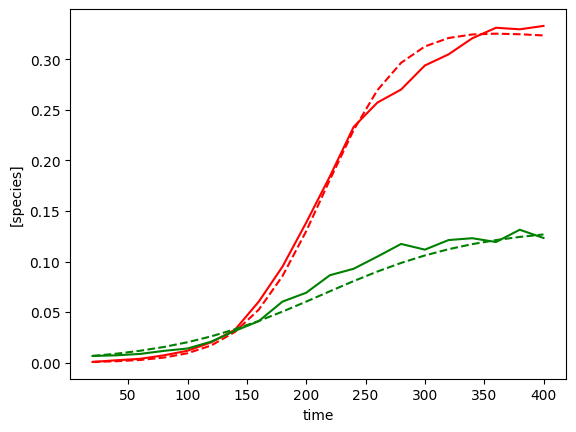

In [5]:
# Define priors
prior_mu_mean = 0.03
prior_mu_sigma = 0.5

prior_Mii_mean =  0.1
prior_Mii_sigma = 0.1

## NB prior_Mij_mean is 0, so not defined as an argument
prior_Mij_sigma = 0.1

# Define parameters for shrinkage on M_ij (non diagonal elements)
n_obs = times.shape[0] - 1
num_species = F.shape[1]
nX = num_species
noise_stddev = 0.1

DA = nX*nX - nX

DA0 = 1     # expected number of non zero entries in M_ij
N = n_obs - 2


# Sampling conditions
draws = 500
tune = 500
chains = 4
cores = 4

# Run inference

inference = infergLVbayes()

inference.set_parameters(X=X, F=F, prior_mu_mean=prior_mu_mean, prior_mu_sigma=prior_mu_sigma,
                          prior_Mii_sigma=prior_Mii_sigma, prior_Mii_mean=prior_Mii_mean,
                          prior_Mij_sigma=prior_Mij_sigma,
                          DA=DA, DA0=DA0, N=N, noise_stddev=noise_stddev,
                          draws=draws, tune=tune, chains=chains,cores=cores)

idata = inference.run_inference_shrinkage()

# To plot posterior distributions
inference.plot_posterior(idata)

# Print summary
summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])


# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

# get median mu_hat and M_hat 
mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0,1) ).reshape(-1)
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1) )

# compare fitted with simulated parameters

predictor = sim_gLV(num_species=num_species, M=M_h.T, mu=mu_h)
yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=yobs[0])
plot_fit_gLV(yobs, yobs_h, times)